In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf

In [109]:
data = yf.download("GOOG")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2023-10-20,138.589996,139.039993,136.244995,136.740005,136.740005,24953900
2023-10-23,136.229996,139.020004,135.110001,137.899994,137.899994,20780700
2023-10-24,139.160004,140.710007,138.750000,140.119995,140.119995,26535200


In [110]:
data = data.reset_index()

In [111]:
prices = data['Close']
prices

0         2.499133
1         2.697639
2         2.724787
3         2.611960
4         2.640104
           ...    
4826    136.740005
4827    137.899994
4828    140.119995
4829    126.669998
4830    123.160004
Name: Close, Length: 4831, dtype: float64

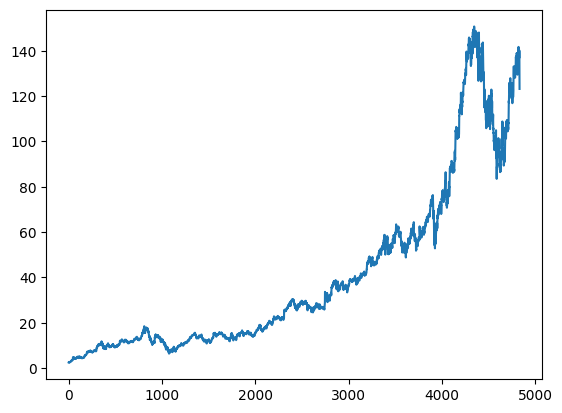

In [112]:
plt.plot(data['Close'])

In [113]:
# Extracting Close prices from dataframe
close_prices = data['Close'].to_numpy().reshape(-1, 1)

In [114]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

In [115]:
scaled_prices

array([[5.54601395e-05],
       [1.39474256e-03],
       [1.57790515e-03],
       ...,
       [9.28557946e-01],
       [8.37813306e-01],
       [8.14132023e-01]])

In [116]:
# Creating training and testing splits
training_split = int((len(scaled_prices) * 0.8))

train_data = scaled_prices[:training_split]
test_data = scaled_prices[training_split:]

In [117]:
train_data.shape, test_data.shape

((3864, 1), (967, 1))

In [118]:
# Use 7 days of close prices to predict the 8th day's close price
WINDOW = 7

# Creating windows and labels in train data
X_train = []
y_train = []

for i in range(WINDOW, len(train_data)):
    X_train.append(train_data[i-WINDOW:i])
    y_train.append(train_data[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape, y_train.shape

((3857, 7, 1), (3857, 1))

In [119]:
# Creating windows and labels in test data

X_test = []
y_test = []

for i in range(WINDOW, len(test_data)):
    X_test.append(test_data[i-WINDOW:i])
    y_test.append(test_data[i])

X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_test.shape, y_test.shape

((960, 7, 1), (960, 1))

In [120]:
# Creating model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

# Compiling the model
model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [121]:
history_1 = model_1.fit(X_train, y_train, epochs=10)

Epoch 1/10
121/121 [==============================] - 5s 13ms/step - loss: 0.0012 - mae: 0.0157
Epoch 2/10
121/121 [==============================] - 1s 11ms/step - loss: 3.1497e-05 - mae: 0.0038
Epoch 3/10
121/121 [==============================] - 1s 11ms/step - loss: 3.1656e-05 - mae: 0.0037
Epoch 4/10
121/121 [==============================] - 1s 11ms/step - loss: 3.2087e-05 - mae: 0.0038
Epoch 5/10
121/121 [==============================] - 1s 11ms/step - loss: 3.3380e-05 - mae: 0.0039
Epoch 6/10
121/121 [==============================] - 1s 11ms/step - loss: 3.4108e-05 - mae: 0.0040
Epoch 7/10
121/121 [==============================] - 1s 11ms/step - loss: 3.7673e-05 - mae: 0.0043
Epoch 8/10
121/121 [==============================] - 2s 14ms/step - loss: 3.6380e-05 - mae: 0.0042
Epoch 9/10
121/121 [==============================] - 2s 13ms/step - loss: 3.5659e-05 - mae: 0.0042
Epoch 10/10
121/121 [==============================] - 1s 11ms/step - loss: 3.0722e-05 - mae: 0.0038


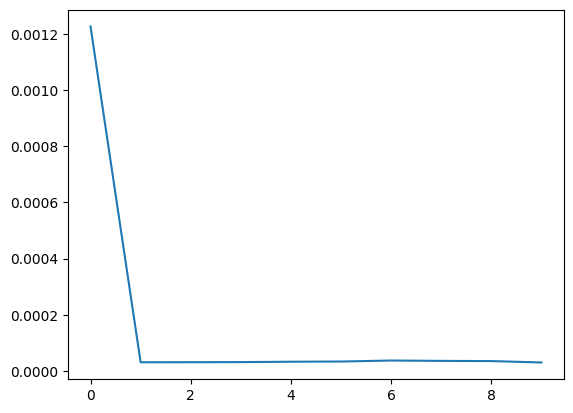

In [122]:
plt.plot(history_1.history['loss'])

30/30 [==============================] - 0s 3ms/step


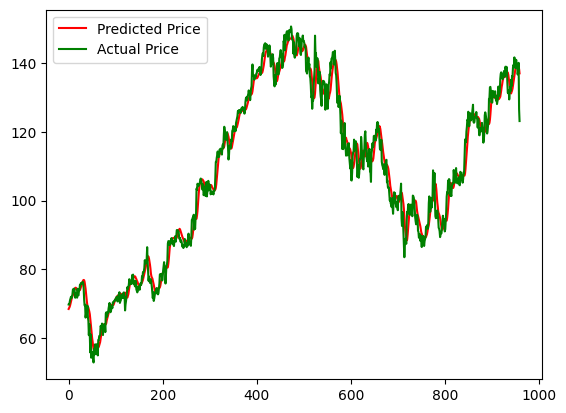

In [124]:
plt.plot(scaler.inverse_transform(model_1.predict(X_test)), c='r', label='Predicted Price')
plt.plot(scaler.inverse_transform(y_test), c='g', label='Actual Price')
plt.legend()
plt.show()

In [128]:
model_1.save("model.h5")